````
AESM1450 - Geophysical Prospecting  -- Controlled-Source ElectroMagnetic (CSEM) Modelling
````
# 6. Inversion

Using the same data as in the previous exercise, we now run an inversion on it.

For the inversion we use `SimPEG`. To see details about the inversion of `SimPEG` works, see 

- => https://www.sciencedirect.com/science/article/pii/S009830041530056X?via%3Dihub
- => https://docs.simpeg.xyz/content/api_core/api_InversionComponents.html
- => https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/index.html

In [1]:
import emg3d
import empymod
import numpy as np
import xarray as xr
import SimPEG, SimPEG.EM
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver

In [2]:
%matplotlib notebook
plt.style.use('default')

## Load data

In [3]:
with xr.open_dataset('./data/Data-3D.nc', engine='h5netcdf') as ds:
    dataset = ds.data.loc[:, :, 'ex', :]

## Data QC

<IPython.core.display.Javascript object>


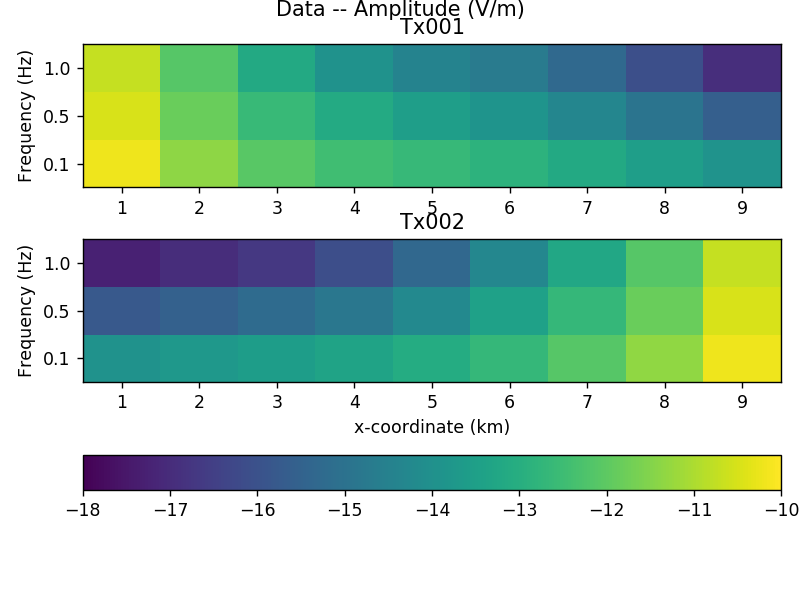

In [4]:
pseudox = np.arange(10)
pseudoy = np.r_[0, 1, 2, 3]
vmin = -18
vmax = -10

fig = plt.figure()
plt.suptitle('Data -- Amplitude (V/m)', y=1)

ax1 = plt.subplot(211)
plt.title('Tx001')
v2data = dataset.loc['Tx001', :, :].values
plt.pcolormesh(pseudox, pseudoy, np.log10(np.abs(v2data)).T, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(9)+0.5, np.arange(1, 10))
plt.yticks(np.arange(3)+0.5, np.r_[0.1, 0.5, 1.0])
plt.ylabel('Frequency (Hz)')

ax2 = plt.subplot(212)
plt.title('Tx002')
v3data = dataset.loc['Tx002', :, :].values
cf0 = plt.pcolormesh(pseudox, pseudoy, np.log10(np.abs(v3data)).T, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(9)+0.5, np.arange(1, 10))
plt.yticks(np.arange(3)+0.5, np.r_[0.1, 0.5, 1.0])
plt.xlabel('x-coordinate (km)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.colorbar(cf0, ax=[ax1, ax2], orientation='horizontal')
plt.show()

In [5]:
# Choose a source and receiver position for this inversion
src_name = 'Tx001'
rec_name = 'Rx005'

# Get the data
data = dataset.loc[src_name, rec_name, :]
vdata = dataset.loc[src_name, rec_name, :].values

# Extract their coordinates
src = [data.srcx.values, data.srcy.values, data.srcz.values]
rec = [data.recx.values, data.recy.values, data.recz.values]

# Extract frequencies
freqs = data.frequency.values

cmp = (src[0]+rec[0])/2

print(f"Src-x : {src[0]:5.0f} m")
print(f"Rec-x : {rec[0]:5.0f} m")
print(f"CMP   : {cmp:5.0f} m")
print("Responses:")
for i, f in enumerate(freqs):
    print(f"{f:5.2} Hz: {vdata[i].real:8.1e}{vdata[i].imag:+8.1e}j")

Src-x :     0 m
Rec-x :  5000 m
CMP   :  2500 m
Responses:
  0.1 Hz:  2.1e-14-2.3e-13j
  0.5 Hz: -2.6e-15+2.9e-14j
  1.0 Hz:  3.3e-15-2.0e-15j


# Inversion => `SimPEG`

For the inversion we use `SimPEG`, which is a huge geophysical framework that does EM, DC, gravity, potentials, and more.

There is one crucial difference between `SimPEG` and `emg3d`: The latter is an iterative solver, whereas the former is a direct solver. While they should yield the same result, the restrictions vary. With a direct solver you will run very quickly into memory issues. We have therefore to keep the numbers of cells as low as possible.

For your laptop it is best if you keep the number of cells below 100,000 cells. If this still saturates your computer's memory then you have to go to smaller models.

## What we know:

- Reservoir layer at -3500 m, 200 m thick.
- Water layer 2 km deep, we can ignore the air
- Background resistivity 1 Ohm.
- Frequencies are from 0.1 to 1 Hz
- Max offset is 9 km.

### From that follows:

- We should have a regular, dense mesh at least 9 km wide, and 1.7 km deep; after that we can stretch.
- The maximum skin depth comes from the highest resistivity and the lowest freq. Let's calculate that.

In [6]:
res_water, res_bg = 0.3, 1.0
seafloor = -2000

sd = 503.3*np.sqrt(np.r_[res_water, res_bg]/freqs.min())

print(f"Max. skind depth (water, background): {sd[0]:5.0f} m; {sd[1]:5.0f} m.")

Max. skind depth (water, background):   872 m;  1592 m.


## TensorMesh

In [7]:
cs = 100
ncx, ncy, ncz = 101, 2, 18
npadx, npady, npadz = 7, 7, 6
pf = 1.5
mesh = SimPEG.Mesh.TensorMesh(
    [[(cs, npadx, -pf), (cs, ncx), (cs, npadx, pf)],
     [(cs, npady, -pf), (cs, ncy), (cs, npady, pf)],
     [(cs, npadz, -pf), (cs, ncz), (cs, npadz, pf)]],
    x0='CCC'
)
mesh.x0[0] += ncx//2*cs
mesh.x0[2] -= ncz//2*cs-cs-seafloor

mesh

TensorMesh: 55,200 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    115     -4,875.78     14,875.78    100.00  1,708.59    1.50
   y     16     -4,925.78      4,925.78    100.00  1,708.59    1.50
   z     30     -6,817.19      1,217.19    100.00  1,139.06    1.50

In [8]:
# v # v # v #   SMALL MESH FOR TESTING ETC - MAYBE ENOUGH?   # v # v # v #

cs = 200
ncx, ncy, ncz = 51, 2, 10
npadx, npady, npadz = 4, 4, 4
pf = 1.8
mesh = SimPEG.Mesh.TensorMesh(
    [[(cs, npadx, -pf), (cs, ncx), (cs, npadx, pf)],
     [(cs, npady, -pf), (cs, ncy), (cs, npady, pf)],
     [(cs, npadz, -pf), (cs, ncz), (cs, npadz, pf)]],
    x0='CCC'
)
mesh.x0[0] += ncx//2*cs
mesh.x0[2] -= ncz//2*cs-cs-seafloor

# ^ # ^ # ^ #   SMALL MESH FOR DEV   # ^ # ^ # ^ #

mesh

TensorMesh: 10,620 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     59     -4,373.92     14,373.92    200.00  2,099.52    1.80
   y     10     -4,473.92      4,473.92    200.00  2,099.52    1.80
   z     18     -8,073.92      2,473.92    200.00  2,099.52    1.80

In [9]:
#mesh.vectorCCx
#mesh.vectorNy
#mesh.vectorNz

## 1D Model, on a 3D Mesh

<IPython.core.display.Javascript object>


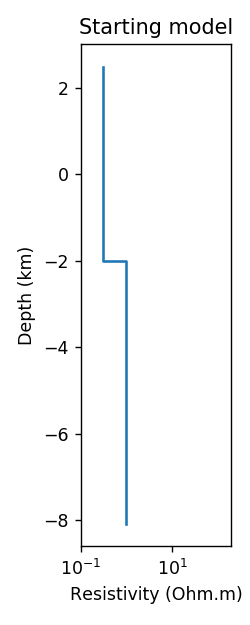

In [10]:
# Let's create a 1D model:
res1d = np.ones(mesh.nCz)*res_water
res1d[mesh.vectorCCz < seafloor] = res_bg

# Put the 1D model onto our 3D mesh
res = np.ones(mesh.vnC)*res1d

# Create a emg3d-Model instance
model = emg3d.utils.Model(mesh, res.ravel('F'))

# QC the 1D model
plt.figure(figsize=(2, 5))
plt.title('Starting model')
pdepth = np.repeat(mesh.vectorNz, 2)[1:-1]/1e3
pres = np.repeat(res1d, 2)
plt.xscale('log')
plt.xlim([0.1, 200])
plt.plot(pres, pdepth)
plt.xlabel('Resistivity (Ohm.m)')
plt.ylabel('Depth (km)')
plt.tight_layout()
plt.show()

# QC the 3D model
#mesh.plot_3d_slicer(np.log10(model.res_x), clim=[-1, 1])

# SimPEG forward model parameters

### Receivers

In [11]:
# Put coordinates in format as required by SimPEG
rec_locs = np.array([[*rec]])

# For SimPEG real and imaginary parts are two different sources
rec_list = [
    SimPEG.EM.FDEM.Rx.Point_e(rec_locs, 'x', 'real'),
    SimPEG.EM.FDEM.Rx.Point_e(rec_locs, 'x', 'imag')
]

### Sources

In [12]:
# Put coordinates in format as required by SimPEG
src_locs = np.array([[*src]])

# We generate the source field with emg3d
# The frequency doesn't motter, as we use then
# sfield.vector, which is independent of frequency.
sfield = emg3d.utils.get_source_field(mesh, [*src, 0, 0], freqs[0])

# Assemble list for all frequencies
src_list = [
    SimPEG.EM.FDEM.Src.RawVec_e(rec_list, s_e=sfield.vector, freq=freqs[0]),
    SimPEG.EM.FDEM.Src.RawVec_e(rec_list, s_e=sfield.vector, freq=freqs[1]),
    SimPEG.EM.FDEM.Src.RawVec_e(rec_list, s_e=sfield.vector, freq=freqs[2]),
]

## Survey and Problem
### Active layers and mappings

In [13]:
# Active layers are all below the seafloor
active = mesh.vectorCCz < seafloor

# Initial and reference model
m0 = np.log(res1d[active])

# Set a SurjectVertical1D mapping
# Note: this sets our inversion model as 1D log resistivity below subsurface
act_map = SimPEG.Maps.InjectActiveCells(mesh, active, np.log(res_water), nC=mesh.nCz)
mapping = SimPEG.Maps.ExpMap(mesh) * SimPEG.Maps.SurjectVertical1D(mesh) * act_map

### Survey

In [14]:
# Create a survey instance
survey = SimPEG.EM.FDEM.Survey(src_list)

# Create a problem and pair the survey
prob = SimPEG.EM.FDEM.Problem3D_e(mesh, rhoMap=mapping, Solver=Solver)
prob.pair(survey)

# Check

We create forward data from our initial model `res1d`, and also calculate this starting model with `empymod`. This way we can check if our mesh is good enough.

In [15]:
# Create forward data for our initial model
simpeg_bg = SimPEG.Survey.Data(survey, dobs=survey.dpred(m0))

spg_bg = np.zeros(3, dtype=complex)
for i, f in enumerate(freqs):
    spg_bg[i] = simpeg_bg[src_list[i], rec_list[0]] + 1j*simpeg_bg[src_list[i], rec_list[1]]
        
# empymod 1D for comparison
epm_bg = empymod.dipole(src, rec, mesh.vectorNz[1:-1], res1d, freqs, verb=1)

<IPython.core.display.Javascript object>


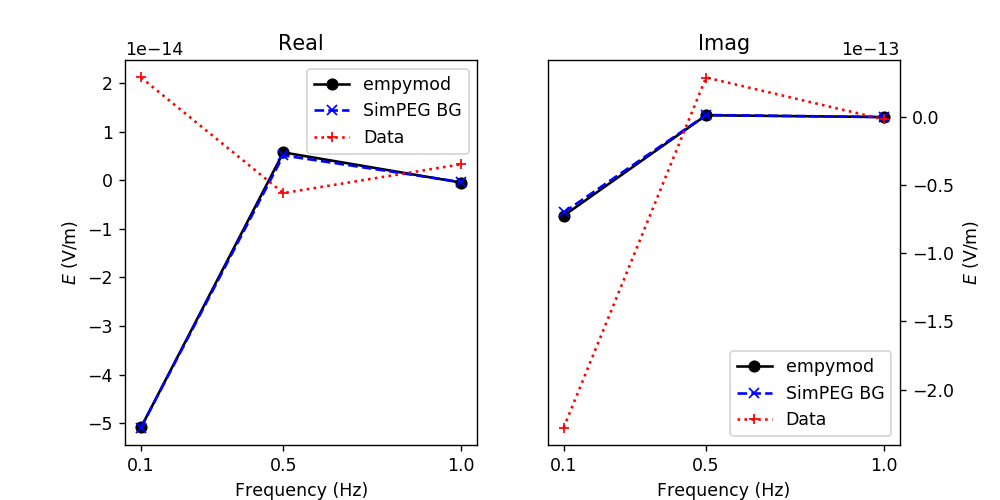

In [16]:
plt.figure(figsize=(8, 4))

ax1 = plt.subplot(121)
plt.title('Real')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$E$ (V/m)')
plt.xticks(freqs)
ax1.plot(freqs, epm_bg.real, 'ko-', label=f"empymod")
ax1.plot(freqs, spg_bg.real, 'bx--', label=f"SimPEG BG")
ax1.plot(freqs, vdata.real, 'r+:', label=f"Data")
plt.legend()

ax2 = plt.subplot(122)
plt.title('Imag')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$E$ (V/m)')
plt.xticks(freqs)
ax2.plot(freqs, epm_bg.imag, 'ko-', label=f"empymod")
ax2.plot(freqs, spg_bg.imag, 'bx--', label=f"SimPEG BG")
ax2.plot(freqs, vdata.imag, 'r+:', label=f"Data")
plt.legend()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

# SimPEG inversion parameters

### Put the data into the required format

In [17]:
dobs = np.c_[vdata.real, vdata.imag].ravel()
survey.dobs = dobs

### Uncertainty, data misfit, regularization, and optimization

In [18]:
# Uncertainty
std = np.ones(dobs.size)*0.01
floor = 1e-15
uncert = abs(dobs) * std + floor

# Data Misfit
dmisfit = SimPEG.DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert

# Regularization
reg_mesh = SimPEG.Mesh.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = SimPEG.Regularization.Simple(reg_mesh)

# Optimization
opt = SimPEG.Optimization.InexactGaussNewton(maxIterCG=10)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


## Initiate inversion

In [19]:
inv_prob = SimPEG.InvProblem.BaseInvProblem(dmisfit, reg, opt)

## Inversion Directives

In [20]:
beta = SimPEG.Directives.BetaSchedule(coolingFactor=4, coolingRate=3)
betaest = SimPEG.Directives.BetaEstimate_ByEig(beta0_ratio=2.)
target = SimPEG.Directives.TargetMisfit()

directive_list = [beta, betaest, target]

## Invert

In [21]:
%%time
inv = SimPEG.Inversion.BaseInversion(inv_prob, directiveList=directive_list)

reg.alpha_s = 5e-1
reg.alpha_x = 1.

prob.counter = opt.counter = SimPEG.Utils.Counter()
opt.remember('xc')

mopt = inv.run(m0)
dpred = inv_prob.dpred

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.77e+01  3.19e+03  0.00e+00  3.19e+03    2.49e+03      0              
   1  1.77e+01  2.95e+02  2.37e+00  3.37e+02    9.31e+02      1              
   2  1.77e+01  2.05e+02  2.02e+00  2.41e+02    1.31e+03      0              
   3  4.44e+00  1.26e+02  1.12e+00  1.31e+02    1.38e+02      0              
   4  4.44e+00  9.96e+01  6.31e+00  1.28e+02    4.85e+02      0              
   5  4.44e+00  9.15e+01  4.18e+00  1.10e+02    1.31e+02      0              
   6  1.11e+00  8.30e+01  5.66e+00  8.93e+01    7.81e+01      0   

## Plot the results

<IPython.core.display.Javascript object>


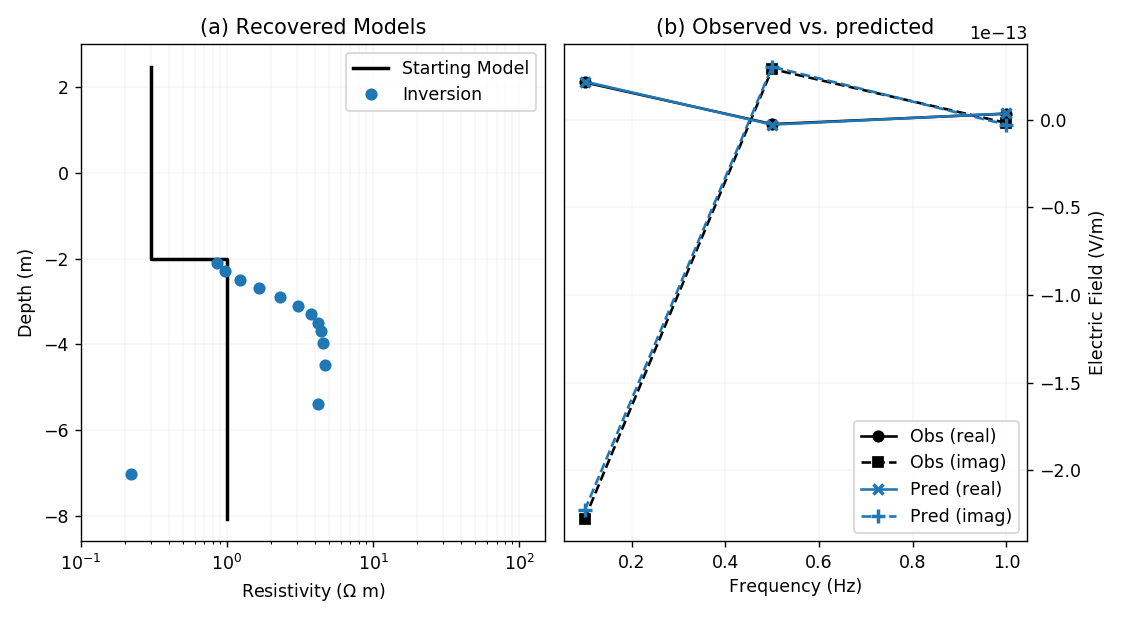

In [22]:
plt.figure(figsize=(9, 5))

# Model
ax1 = plt.subplot(121)
plt.title("(a) Recovered Models")

# Background model
plt.plot(pres, pdepth, 'k-', lw=2, label="Starting Model")

# Inverted model
plt.plot(np.exp(mopt), mesh.vectorCCz[active]/1e3, 'C0o', ms=6, label='Inversion')

plt.legend()
plt.xscale('log')
plt.xlim([0.1, 150])
plt.xlabel('Resistivity ($\Omega$ m)')
plt.ylabel('Depth (m)')
ax1.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)


# Data
ax2 = plt.subplot(122)
plt.title("(b) Observed vs. predicted")

# Observed data
plt.plot(freqs, vdata.real, 'ko-', label="Obs (real)")
plt.plot(freqs, vdata.imag, 'ks--', label="Obs (imag)")

# Inversion result
plt.plot(freqs, dpred[::2], 'C0x-', mew=2, label="Pred (real)")
plt.plot(freqs, dpred[1::2], 'C0+--', mew=2, ms=8, label="Pred (imag)")

#plt.yscale('symlog', linthreshy=1e-13)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Electric Field (V/m)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)

plt.tight_layout()
plt.show()

In [23]:
empymod.Report([emg3d, SimPEG])

--------------------------------------------------------------------------------
  Date: Fri Feb 28 10:02:08 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

             emg3d : 0.9.3
            SimPEG : 0.13.1
             numpy : 1.17.2
             scipy : 1.3.1
           empymod : 1.10.5
           numexpr : 2.7.0
           IPython : 7.8.0
        matplotlib : 3.1.1

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------